# Benchmark Pan 2014 para esse problema

resultados com micro-avg < 0.30  foram removidos

|Team                  |Dutch    |English    |Greek     |Spanish     |Micro-avg|Macro-avg|
|----------------------|--------:|----------:|---------:|-----------:|--------:|--------:|
|Bagnall               |0.451    |**0.614**  |**0.750** |0.721       |0.608    |0.628    |
|Bartoli et al.        |0.518    |0.323      |0.458     |**0.773**   |0.417    |0.506    |
|Moreau et al.         |**0.635**|0.453      |**0.693** |0.661       |0.534    |0.606    |
|Gutierrez et al.      |0.329    |0.513      |0.581     |0.509       |0.479    |0.478    |
|Halvani               |0.455    |0.458      |0.493     |0.441       |0.445    |0.462    |
|Hürlimann et al.      |0.616    |0.412      |0.599     |0.539       |0.487    |0.538    |
|Pacheco et al.        |0.624    |0.438      |0.517     |0.663       |0.480    |0.558    |
|PAN15-ENSEMBLE        |0.426    |0.468      |0.537     |0.715       |0.475    |0.532    |
|PAN14-BASELINE-2      |0.191    |0.409      |0.412     |0.683       |0.406    |0.405    |
|PAN13-BASELINE        |0.242    |0.404      |0.384     |0.367       |0.358    |0.347    |

## Bibliotecas

In [1]:
%matplotlib inline
#bibliotecas padrões do python
import os;
import codecs;
import random;
import zipfile;
import json;
import re;
import math;
import pickle;
from __future__ import print_function;

#bibliotecas científicas
import matplotlib.pyplot as plt;
import numpy as np;
import pandas as pd;

from scipy.spatial import distance as sdistance 
#bibliotecas para machine learning
from sklearn.pipeline import Pipeline;
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer;

from sklearn.metrics.pairwise  import cosine_similarity, paired_distances;
from sklearn.preprocessing     import RobustScaler, MaxAbsScaler, MinMaxScaler, normalize;
from sklearn.decomposition     import PCA;
from sklearn.feature_selection import SelectPercentile,SelectFpr, f_classif, chi2;
from sklearn.model_selection   import StratifiedKFold,  GridSearchCV;
from sklearn.pipeline          import Pipeline;
from sklearn.metrics           import f1_score, pairwise_distances, precision_recall_fscore_support, roc_auc_score,accuracy_score;

from sklearn.linear_model      import LogisticRegression;
from sklearn.metrics           import classification_report, roc_curve;


import seaborn as sns;

#import statsmodels.discrete.discrete_model as sm;

#bibliotecas customizadas.
from toolboxAnalytics import  rocKS, rocCurve, ksCurve;
from IPython.core.display import display, HTML, Markdown;

np.set_printoptions(precision=3);

## Leitura dos datasets por tipo

In [2]:
def readFilesProfile(task, corpus):
            #pan14-author-verification-training-corpus-english-essays-2014-04-22
    base = 'pan14-author-verification-'+corpus+'-'+task+'-2014-04-22';
    
    problems = [];
    with zipfile.ZipFile(base+'.zip') as z:
        with z.open(base+'/truth.json') as fcontent:
            namelist = [name  for name in z.namelist()];
            content = json.load(fcontent);
            for problem in content['problems']:
                problemFolder = base+'/'+problem['name'];
                known = '';
                unknown = '';
                docCount = 0;
                for name in namelist:
                    if problemFolder+'/known' in name:
                        with z.open(name) as f:
                            known += f.read();
                            docCount +=1;
                    elif problemFolder+'/unknown' in name:
                        with z.open(name) as f:
                            unknown += f.read();
                problem['known'] = known;
                problem['unknown'] = unknown;
                problem['corpus'] = corpus;
                problem['docCount'] = docCount;
                problem['profileSize'] = len(known);
                problem['profileSizeMean'] = len(known)/docCount;
                problem['unknownSize'] = len(unknown);
                problems.append(problem);
    return problems;

In [3]:
#tasks = ['dutch-essays', 'dutch-reviews','english-essays','english-novels', 'greek-articles', 'spanish-articles'];
tasks = ['english-novels','english-essays']
corpus = ['training-corpus','test-corpus1','test-corpus2']
dataset = [
        pd.DataFrame(readFilesProfile(t,c))
            for t in tasks
                for c in corpus
        ]
dataset = pd.concat(dataset);

dataset.head()

,answer,corpus,docCount,genre,known,language,name,profileSize,profileSizeMean,unknown,unknownSize
0,N,training-corpus,1,novels,"﻿The world we live in is not as it seems. I, J...",english,EN001,3724,3724,VII.\n\nYet all this was only the prologue of ...,14659
1,Y,training-corpus,1,novels,V. A Nightmare and a Cataclysm\n\n1.\n\nAnd no...,english,EN002,82749,82749,"II.\n\nIt was in the township of Dunwich, in a...",8596
2,N,training-corpus,1,novels,III. A Search and an Evocation\n\n1.\n\nCharle...,english,EN003,61619,61619,"﻿April 20th, 1909\nThey have given me one hour...",17995
3,Y,training-corpus,1,novels,"﻿Birth Right\nMantineus-I'm more Mr. Briggs, t...",english,EN004,10534,10534,"﻿The Judas Mark\n""Cthulhu ftaghn,"" He said wit...",5418
4,Y,training-corpus,1,novels,﻿An autumnal chill descended upon the streets ...,english,EN005,23106,23106,"﻿May 19th, 1929,\nMiskatonic University, Arkha...",13487


# Partindo dos dados consolidados previamente

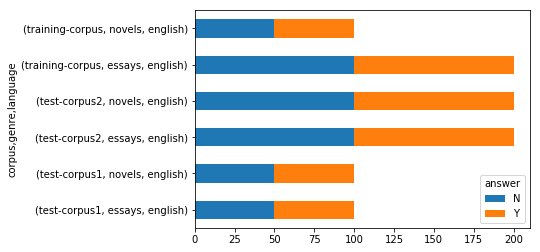

In [4]:
dataset\
.pivot_table(values='name',index=['corpus','genre','language'],columns='answer',aggfunc='count') \
.plot.barh(stacked=True);

In [5]:
dataset[dataset.corpus == 'training-corpus'].groupby(['genre','docCount']).agg({'profileSize':np.mean, 'profileSizeMean':np.mean, 'name':np.size})

profileSizeMean  name   profileSize
genre  docCount                                     
essays 1             4367.140351    57   4367.140351
       2             4749.857143    42   9500.238095
       3             4728.468750    32  14186.687500
       4             4851.679245    53  19408.245283
       5             5088.000000    16  25442.250000
novels 1            25409.700000   100  25409.700000

# Funções utilitárias

In [6]:
def cosine(matrixA, matrixB):
    """Essa função calcula a similaridade de cossenos entre duas matrizes e retorna um vetor que representa
    cosine[i] =  cosine(matrixA[i,:], matrixB[i,:])
    como preprocessamento, a matrizes passam por um normalização L2 para evitar que a norma influencie
    """
    return np.array(np.diag(
        cosine_similarity(
            normalize(matrixA, norm='l2'),
            normalize(matrixB, norm='l2')
        )
    )).flatten();

In [7]:
def CNG_Keselj(matrixA, matrixB):
    """
    A profile-based method of particular interest, the Common n-Grams (CNG) approach, was described by Keselj, et al. (2003).
    -1 vetor A tem valores maiores
    0  A e B são iguais
    1  vetor B  tem valores maiores
    """
    matrixA = normalize(matrixA, norm='l1')
    matrixB = normalize(matrixB, norm='l1')
    dif   = (matrixA) - (matrixB);
    summ   = (matrixA) + (matrixB);
    
    s = (2 * dif /summ) **2;
    s = np.array(np.nansum(s, axis=1)).flatten();    
    return s;

In [8]:
def CNG_Stamatatos(matrixA, matrixB):
    matrixA = normalize(matrixA, norm='l1')
    matrixB = normalize(matrixB, norm='l1')
    
    #difference to local
    s1 = (2 * (matrixA - matrixB) /(matrixA + matrixB)) **2;
    
    
    #global difference
    matrixCorpus = np.vstack((matrixA,matrixB));
    matrixCorpus =  normalize(np.sum(matrixCorpus,axis=0, keepdims=True), norm='l1');   
    s2 = (2 * (matrixA - matrixCorpus) /(matrixA + matrixCorpus)) **2;
    
    s = s1 * s2;    
    s = np.array(np.nansum(s, axis=1)).flatten();    
    return s;

In [9]:
def cScore(Y,Ypred):
    """função definida segundo a competição pan.  A ideia é penalisar o classificador
    que retorna probabilidade de 50%, ou seja, não ser melhor que um chute aleatório """
    Ypred = np.round(Ypred,decimals=3);
    n  = len(Y)*1.0;
    nunansweard  = np.sum(Ypred == 0.5);
    
    ncorrect = np.sum( (Ypred>0.5) & (Y == 1) ) + np.sum( (Ypred<0.5) & (Y == 0) )    
    #ncorrect = np.sum(((Ypred>0.5) == Y)) - nunansweard;    
    return (1.0/n)*(ncorrect+(nunansweard*ncorrect/n));

In [10]:
def difchi2(ma, mb):
    return np.log(1+(np.array(ma) - np.array(mb))**2 /(1+ np.array(ma)));


def kpi(pred, y):
    ks      = ksCurve(pred,y);
    roc     = rocCurve(pred,y);
    c_score = cScore  (pred,y);
    final   = roc * c_score;
    return ks, roc, c_score, final;


def kpi2(pred, y):
    roc     = rocCurve(pred,y);
    c_score = cScore  (pred,y);
    metrics =  {
        'ks':ksCurve(pred,y),
        'auc':roc,
        'C_score': c_score,
        'f1': f1_score(y, pred),
        'PAN' : roc * c_score
        
    };
    return metrics;

## Filtrando as instancias de problemas que serão tratadas

Foi utilizado apenas o corpus de trainamento porque os corpus de teste estariam disponíveis apenas para o avaliadores.

In [11]:
datasetEstudo = dataset[dataset.corpus == 'training-corpus']
datasetEstudo = datasetEstudo[['name','language','genre','known','unknown','answer']];
datasetEstudo.head()

,name,language,genre,known,unknown,answer
0,EN001,english,novels,"﻿The world we live in is not as it seems. I, J...",VII.\n\nYet all this was only the prologue of ...,N
1,EN002,english,novels,V. A Nightmare and a Cataclysm\n\n1.\n\nAnd no...,"II.\n\nIt was in the township of Dunwich, in a...",Y
2,EN003,english,novels,III. A Search and an Evocation\n\n1.\n\nCharle...,"﻿April 20th, 1909\nThey have given me one hour...",N
3,EN004,english,novels,"﻿Birth Right\nMantineus-I'm more Mr. Briggs, t...","﻿The Judas Mark\n""Cthulhu ftaghn,"" He said wit...",Y
4,EN005,english,novels,﻿An autumnal chill descended upon the streets ...,"﻿May 19th, 1929,\nMiskatonic University, Arkha...",Y


# Análise exploratória da base

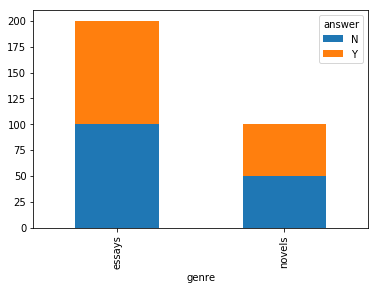

In [12]:
datasetEstudo.pivot_table(
    values='name',
    index=['genre'],
    columns='answer',aggfunc='count').plot.bar(stacked=True);

# analisando char n-grams  mais frequentes
Segundo a literatura (survery do stamatatos) o termos mais frequentes permitem diferenciar o autor sem ser impactados pelo contexto.
Estudando apontam também que entre 2 e 5 char n-grams apresentaram os melhores resultados.
Utilizando o TfidfVectorizer  sem a componente IDF porque ela faz pouco efeito e para utilizar a versão com 1+log(TF)

In [13]:
counter = CountVectorizer(
        analyzer="char",
        min_df=0.70,
        max_df=1.0,
        ngram_range=(2,5),
        lowercase=False,
        dtype=np.float32
    );

In [14]:
counter.fit(datasetEstudo.known.values);
ma = counter.transform(datasetEstudo.known.values).todense();
mb = counter.transform(datasetEstudo.unknown.values).todense();

In [15]:
def normalizer(m):
    #TF
    m = normalize(m,norm='l1');
    return m;    

In [16]:
known = normalizer(ma);
unknown = normalizer(mb);

In [17]:
def fuzzyyulef(u, v, w=None):
    nff = np.minimum(u,v).sum();
    ntf = u[u > v].sum();
    nft = v[v > u].sum();
    ntt = np.maximum(u,v).sum();
    return float(2.0 * ntf * nft / np.array(ntt * nff + ntf * nft))

In [18]:
pca = PCA(0.95).fit(np.vstack((known,unknown)));

distances =[
    ("keselj",    CNG_Keselj(known,unknown)),
    ("stamatatos",CNG_Stamatatos(known,unknown)),
    ("jaccard",   paired_distances(known>0, unknown>0, metric=sdistance.jaccard)),
    #("correlation", paired_distances(known, unknown, metric=sdistance.correlation)),
    ("cosine",    paired_distances(known, unknown, metric='cosine')),
    ("cosineABpca", 1-paired_distances(pca.transform(known), pca.transform(unknown), metric=sdistance.cosine)),
    #("braycurtis",paired_distances(known, unknown, metric=sdistance.braycurtis)),
    #("chebyshev", paired_distances(known*100, unknown*100, metric=sdistance.chebyshev)),
    #("canberra",  paired_distances(known, unknown, metric=sdistance.canberra)),
    #("fuzzyyule", paired_distances(known, unknown, metric=fuzzyyulef)),
    #("yule",      1-paired_distances(known!=0, unknown!=0, metric=sdistance.yule)),
        #("sokalmichener",1-paired_distances(known>0, unknown>0, metric=sdistance.sokalmichener)),
        #("sokalsneath",1-paired_distances(known>0, unknown>0, metric=sdistance.sokalsneath)),
        #("dice",1-paired_distances(known>0, unknown>0, metric=sdistance.dice)),
        #("kulsinski", 1-paired_distances(known>0, unknown>0, metric=sdistance.kulsinski)),
        
];

/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in divide
  del sys.path[0]
/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in divide
  del sys.path[0]
/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in divide
  
/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in divide
  


# Análise descritiva das variáveis criadas

In [19]:
def ks_binary(x,y, dtype=np.float32):
    notNAN= np.isnan(x)==False;
    y = y[notNAN];
    x = x[notNAN]; 
    
    argsorted = x.argsort();
    
    cdfFalse = (y[argsorted]==False).cumsum(dtype=dtype);
    cdfFalse /= cdfFalse[-1];

    cdfTrue = (y[argsorted]).cumsum(dtype=dtype);
    cdfTrue /= cdfTrue[-1];
    
    ks = np.abs(cdfFalse - cdfTrue).max();
    ks_stab = np.mean((cdfFalse - cdfTrue) >0);
    if ks_stab != 1 and ks_stab != 0:
        ks_entropy = - (ks_stab*np.log(ks_stab) + (1-ks_stab)*np.log(1-ks_stab));
    else:
        ks_entropy = 0;
    return ks, ks_entropy, argsorted, cdfFalse, cdfTrue;
    

In [20]:
def histKS(var, truth, cutoff=2.5,bins=30,colors=['#FF4444', '#4444FF'], labels=['False','True'], density=False):
    notNAN= np.isnan(var)==False;
    truth=truth[notNAN];
    var = var[notNAN];
    
    var = np.clip(var,a_min=np.percentile(var,cutoff), a_max=np.percentile(var,100-cutoff));
    plt.xlim((np.percentile(var,cutoff), np.percentile(var,100-cutoff)))
    plt.hist(var[truth == False], label=labels[0], bins=bins, color=colors[0], alpha=0.5);
    plt.hist(var[truth], label=labels[1], bins=bins,color=colors[1], alpha=0.5);
    
    ax2 = plt.twinx()
    
    ks, ks_entropy, argsorted, cdfFalse, cdfTrue = ks_binary(var, truth)
    ax2.plot(var[argsorted],cdfFalse,color=colors[0], label=labels[0])
    ax2.plot(var[argsorted],cdfTrue,color=colors[1], label=labels[1])
    ax2.set_ylim((0.0,1.05))

    plt.xlabel(u"Distância");
    plt.legend(loc='best')
    return ks, ks_entropy;


3.0


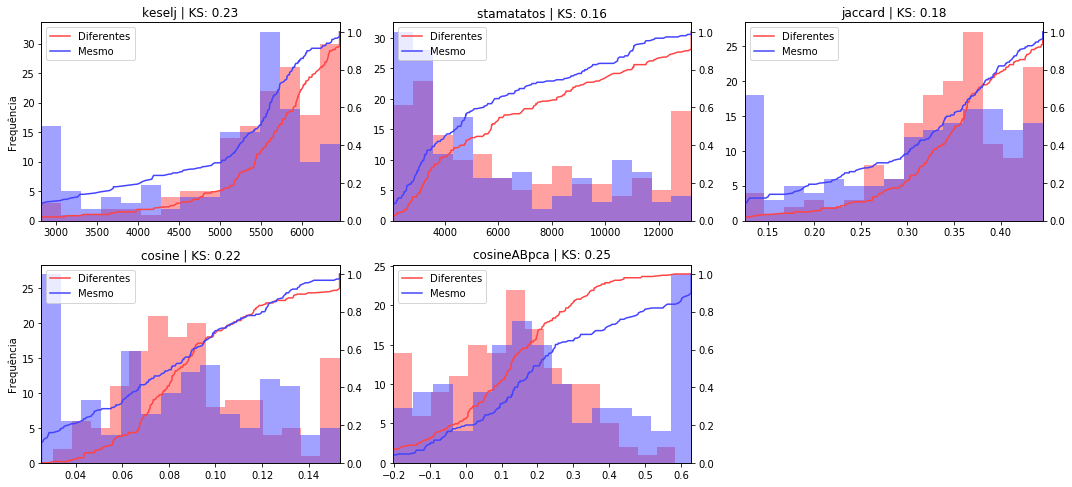

In [21]:
Y = datasetEstudo.answer.values=="Y";
q = math.ceil(math.sqrt(len(distances)*1.0));
print (q)
plt.figure(figsize=(15,10))
for i, d in enumerate(distances):
    #print(d[0],' ', i)
    plt.subplot(q,q,i+1);
    if i % q == 0:
        plt.ylabel(u"Frequência");
    ks = histKS(d[1], Y, cutoff=5, bins=15, labels=['Diferentes','Mesmo']);
    plt.title("%s | KS: %0.2f" % (d[0], ks[0]));
plt.tight_layout();
plt.show();

In [22]:
Y = datasetEstudo.answer.values=="Y";
KS = pd.DataFrame(
    {'Dissimilaridade':[m[0] for m in distances],
    'Kolmogorov-Smirnov': [ks_binary(m[1], Y)[0] for m in distances],
     'Kolmogorov-Smirnov entropy': [ks_binary(m[1], Y)[1] for m in distances],
    'fClassifDF': np.round([(f_classif(m[1].reshape(-1, 1), Y)[1])[0] for m in distances],3)
    }
);
#KS.plot(kind='bar',x='Dissimilaridade', y='Kolmogorov-Smirnov');
pd.set_option('precision',4)
#KS.to_clipboard(excel=True);
KS.sort_values('Kolmogorov-Smirnov')


,Dissimilaridade,Kolmogorov-Smirnov,Kolmogorov-Smirnov entropy,fClassifDF
1,stamatatos,0.1600,0.0223,0.002
2,jaccard,0.1800,0.1985,0.002
3,cosine,0.2200,0.3864,0.004
0,keselj,0.2267,0.0223,0.000
4,cosineABpca,0.2467,0.0223,0.000


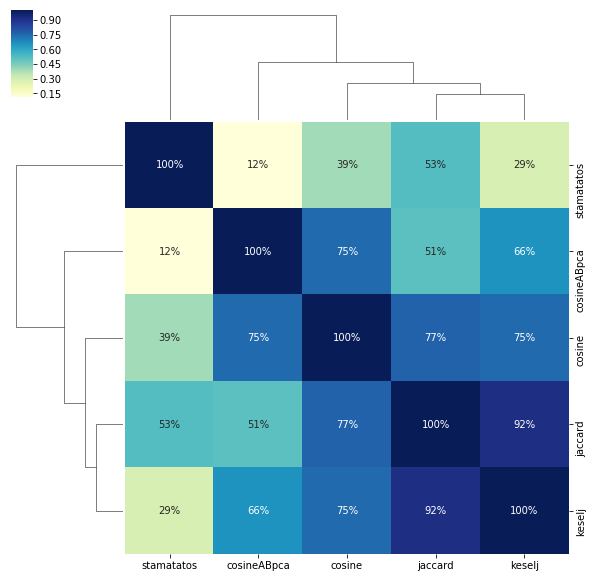

In [23]:
Attr = pd.DataFrame(dict(distances));
Attr
corr = Attr.corr()
sns.clustermap(corr.abs(),annot=True, cmap="YlGnBu", fmt='.0%',
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

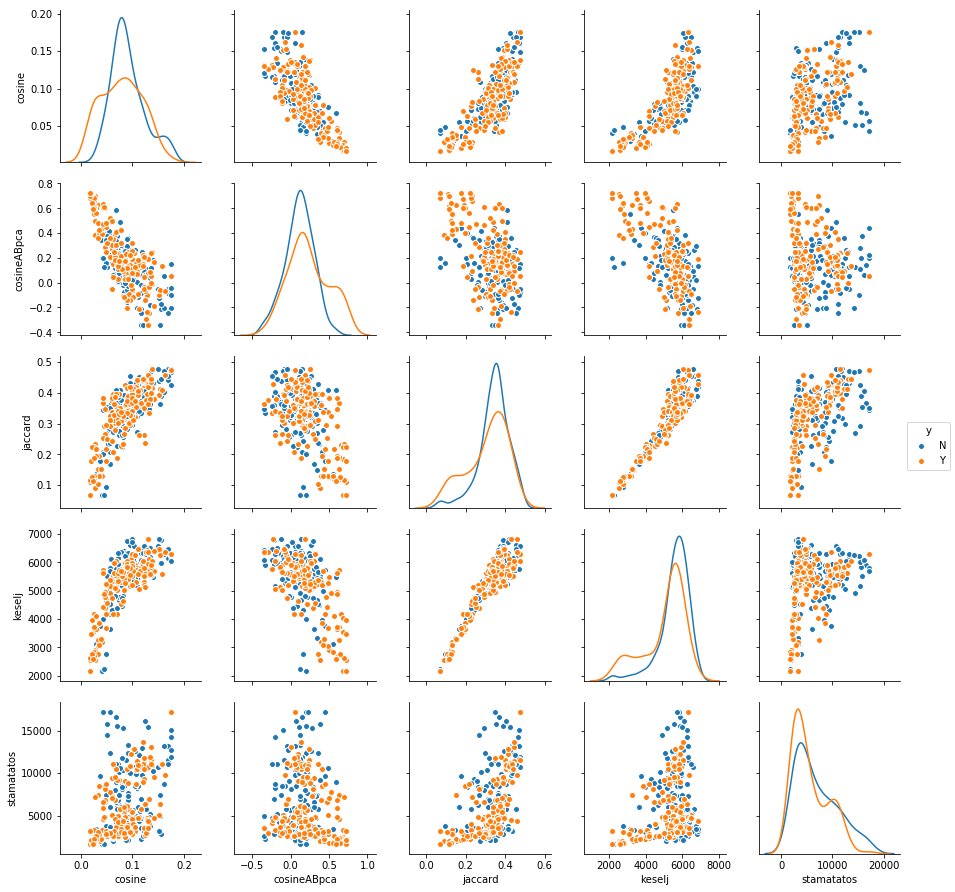

In [24]:
def clipping(arr, cutoff):
    a = np.clip(arr, a_min=np.percentile(arr,cutoff), a_max= np.percentile(arr, 100-cutoff))
    return a;

d = pd.DataFrame(dict([(m[0],clipping(m[1],1)) for m in distances]));
d['y']=datasetEstudo.answer.values
sns.pairplot(d,   hue="y", diag_kind='kde');

# Classificador utilizando as funções de similiaridade

In [25]:
XK = datasetEstudo.known.values;
XU = datasetEstudo.unknown.values;
Y = datasetEstudo.answer.values=="Y";

In [26]:
kf = StratifiedKFold(n_splits=5, random_state =0);

counter = CountVectorizer(
        analyzer="char",
        min_df=0.90,
        max_df=1.0,
        ngram_range=(2,5),
        lowercase=False,
        dtype=np.float32
    );

pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA()),
    ('clf', LogisticRegression(random_state = 0)) 
]);

pipeline2 = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('clf', LogisticRegression(random_state = 0)) 
]);

In [27]:
modelsResults = [];

i =0;

for train_index, test_index in kf.split(XK, Y):
    i=i+1;
    print("\niniciando iteração %d" % i);
    
    XKtrain, XKtest = XK[train_index], XK[test_index];
    XUtrain, XUtest = XU[train_index], XU[test_index];
    YTrain , YTest  = Y[train_index] , Y[test_index];
    
    print("counter");
    counter.fit(np.append(XKtrain,XUtrain));
    XKtrain, XKtest = counter.transform(XKtrain).todense(), counter.transform(XKtest).todense();
    XUtrain, XUtest = counter.transform(XUtrain).todense(), counter.transform(XUtest).todense();
    
    XKtrain, XKtest  = normalizer(XKtrain), normalizer(XKtest);
    XUtrain, XUtest  = normalizer(XUtrain), normalizer(XUtest);    
    
    
    print("X training");  
    pca = PCA(0.95);
    pca.fit(np.vstack((XKtrain,XUtrain)));
    
    cosineABtrain    = cosine(XKtrain,XUtrain);
    cosineABpcatrain = cosine(pca.transform(XKtrain),pca.transform(XUtrain));    
    Statamatostrain  = CNG_Stamatatos(XKtrain, XUtrain);
    keseljtrain      = CNG_Keselj(XKtrain, XUtrain);
    jaccardtrain     = np.diag(pairwise_distances(XKtrain > 0, XUtrain >0, metric='jaccard'));
    
    Xtrain = np.vstack((cosineABtrain, cosineABpcatrain , Statamatostrain, keseljtrain, jaccardtrain)).T;
    
    print("X test");
    cosineABtest     = cosine(XKtest,XUtest);
    cosineABpcatest  = cosine(pca.transform(XKtest),pca.transform(XUtest));   
    Statamatostest   = CNG_Stamatatos(XKtest, XUtest);
    keseljtest       = CNG_Keselj(XKtest, XUtest);
    jaccardtest      = np.diag(pairwise_distances(XKtest > 0, XUtest >0, metric='jaccard'));
    
    Xtest = np.vstack((cosineABtest, cosineABpcatest , Statamatostest, keseljtest, jaccardtest)).T;
    
    modesl = ['cosineAB', 'cosinePCA', 'Stamatatos','keselj','jaccard'];
    for j in range(Xtrain.shape[1]):
            print("modelo  %s"%modesl[j]);
            pipeline2.fit(Xtrain[:,j].reshape(-1,1),YTrain);
            predTrain = pipeline2.predict_proba(Xtrain[:,j].reshape(-1,1));
            predTest = pipeline2.predict_proba(Xtest[:,j].reshape(-1,1));
            
            precision, recall, f1, _ = precision_recall_fscore_support(YTest, predTest[:,1]>0.5,average='macro')

            modelsResults.append({        
                'kfold'     : i,
                'model'     :modesl[j],
                'train': roc_auc_score(YTrain, predTrain[:,1]),
                'test' : roc_auc_score(YTest, predTest[:,1]),
                'accuracy':accuracy_score(YTest, predTest[:,1]>0.5),
                'precision':precision,
                'recall':recall,
                'f1':f1,
                'cscore':cScore(YTest, predTest[:,1])
            })  ;
    
    print("modelo  mp2");
    Xtrain = np.vstack((cosineABtrain, cosineABpcatrain , Statamatostrain)).T;
    Xtest  = np.vstack((cosineABtest, cosineABpcatest , Statamatostest)).T;
    pipeline.fit(Xtrain,YTrain);
    predTrain = pipeline.predict_proba(Xtrain);
    predTest = pipeline.predict_proba(Xtest);
    precision, recall, f1, _ = precision_recall_fscore_support(YTest, predTest[:,1]>0.5,average='macro')
    
    modelsResults.append({        
        'kfold'     : i,
        'model'     :'mp2_mix',
        'train': roc_auc_score(YTrain, predTrain[:,1]),
        'test' : roc_auc_score(YTest, predTest[:,1]),
        'accuracy':accuracy_score(YTest, predTest[:,1]>0.5),
        'precision':precision,
        'recall':recall,
        'f1':f1,
        'cscore':cScore(YTest, predTest[:,1])
    })  ;
    
    print("modelo CNG distancia 2");
    Xtrain = difchi2(XKtrain,XUtrain);
    Xtest = difchi2(XKtest,XUtest);
    
    pipeline.fit(Xtrain,YTrain);
    predTrain = pipeline.predict_proba(Xtrain);
    predTest = pipeline.predict_proba(Xtest);
    precision, recall, f1, _ = precision_recall_fscore_support(YTest, predTest[:,1]>0.5,average='macro')
    
    modelsResults.append({        
        'kfold'     : i,
        'model'     :'MP1_bow',
        'train': roc_auc_score(YTrain, predTrain[:,1]),
        'test' : roc_auc_score(YTest, predTest[:,1]),
        'accuracy':accuracy_score(YTest, predTest[:,1]>0.5),
        'precision':precision,
        'recall':recall,
        'f1':f1,
        'cscore':cScore(YTest, predTest[:,1])
    });


iniciando iteração 1
counter
X training
X test
modelo  cosineAB
modelo  cosinePCA
modelo  Stamatatos
modelo  keselj
modelo  jaccard
modelo  mp2
modelo CNG distancia 2


/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in divide
  
/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in divide
  
/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in divide
  del sys.path[0]
/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in divide
  del sys.path[0]



iniciando iteração 2
counter
X training
X test
modelo  cosineAB
modelo  cosinePCA
modelo  Stamatatos
modelo  keselj
modelo  jaccard
modelo  mp2
modelo CNG distancia 2

iniciando iteração 3
counter
X training
X test
modelo  cosineAB
modelo  cosinePCA
modelo  Stamatatos
modelo  keselj
modelo  jaccard
modelo  mp2
modelo CNG distancia 2

iniciando iteração 4
counter
X training
X test
modelo  cosineAB
modelo  cosinePCA
modelo  Stamatatos
modelo  keselj
modelo  jaccard
modelo  mp2
modelo CNG distancia 2

iniciando iteração 5
counter
X training
X test
modelo  cosineAB
modelo  cosinePCA
modelo  Stamatatos
modelo  keselj
modelo  jaccard
modelo  mp2
modelo CNG distancia 2


In [28]:
df =pd.DataFrame(modelsResults);
df['final'] = df.test * df.cscore;
df=df.groupby(by=['model']).mean()[['test','cscore','final','accuracy']].sort_values('test')
df.to_clipboard(excel=True)
df

,test,cscore,final,accuracy
model,,,,
jaccard,0.5928,0.5599,0.3343,0.5600
Stamatatos,0.5931,0.5554,0.3338,0.5567
keselj,0.6049,0.5453,0.3332,0.5433
mp2_mix,0.6289,0.5354,0.3418,0.5367
cosinePCA,0.6398,0.5533,0.3548,0.5533
cosineAB,0.6402,0.5048,0.3267,0.5033
MP1_bow,0.7273,0.6767,0.4989,0.6767


Text(0.5,1,'KS 0.30')

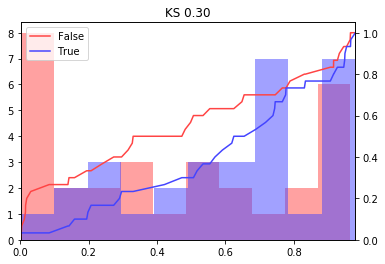

In [29]:
ks,_ = histKS(predTest[:,1], YTest, cutoff=0, bins=10)
plt.title("KS %0.2f"%ks)